# RNN (LSTM)

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
plt.style.use("ggplot")
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
import tools.helper_functions as hf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Bidirectional, Activation
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading data set
df = pd.read_excel('data/eth_api_data.xlsx')
df.set_index('t', inplace=True)

In [3]:
price_data = df.filter(['price_usd_close'])

In [4]:
ts = price_data.values

In [5]:
# Normalizing/Scaling the Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(ts)

In [6]:
train_set_len = int(np.ceil(len(ts) * .9))
train_set = scaled_data[0:int(train_set_len), :]
test_set = scaled_data[train_set_len:, :]

In [7]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [8]:
def train_val(price_data):
    train_size = int(len(price_data) * 0.9)
    train = price_data[0:train_size]
    val = price_data[train_size:len(price_data)]
    return train, val

In [9]:
def prepare_training(price_data, n_steps_in, n_steps_out):
    train, val = train_val(price_data)
    x_train, y_train = split_sequences(train, n_steps_in, n_steps_out)
    x_val, y_val = split_sequences(val, n_steps_in, n_steps_out)
    features = 1
    return x_train, y_train, x_val, y_val, features

In [10]:
n_steps_in, n_steps_out = 90 , 30
x_train, y_train, x_val, y_val, feature = prepare_training(train_set, n_steps_in, n_steps_out)

In [11]:
# simple Encoder-Decoder model
def cmod_1(n_steps_in, n_steps_out, features):
    mod_1 = Sequential()
    mod_1.add(LSTM(128, activation='relu', return_sequences=False, input_shape=(n_steps_in, features)))
    mod_1.add(RepeatVector(n_steps_out))
    mod_1.add(LSTM(128, activation='relu', return_sequences=False))
    mod_1.add(Dense(features))
    
    mod_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return mod_1

In [12]:
# simple lstm model
def cmod_2(n_steps_in, n_steps_out, features):
    mod_2 = Sequential()
    mod_2.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, features)))
    mod_2.add(LSTM(50, activation='relu'))
    mod_2.add(Dense(n_steps_out))
    mod_2.add(Activation('linear'))
    
    mod_2.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])
    
    return mod_2

In [13]:
#Stop training when a monitored metric has stopped improving.
stop = EarlyStopping(monitor='val_loss',patience=5)

#Reduce learning rate when a metric has stopped improving.
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

opt = optimizers.Adam(learning_rate=0.0001)

model 1

In [14]:
mod_1 = cmod_1(n_steps_in, n_steps_out, feature)

In [15]:
hist_1 = mod_1.fit(x_train, y_train, epochs=100, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[stop,reduce])

Epoch 1/100
34/34 [==============================] - 3s 97ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 2/100
34/34 [==============================] - 3s 89ms/step - loss: 4.6530e-04 - mean_squared_error: 4.6530e-04 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 3/100
34/34 [==============================] - 3s 91ms/step - loss: 4.4738e-04 - mean_squared_error: 4.4738e-04 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 4/100
34/34 [==============================] - 3s 90ms/step - loss: 4.2895e-04 - mean_squared_error: 4.2895e-04 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 5/100
34/34 [==============================] - 3s 89ms/step - loss: 4.4113e-04 - mean_squared_error: 4.4113e-04 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 6/100
34/34 [==============================] - 3s 90ms/step - loss: 4.0410e-04 - mean_squared_error: 4.0410e-04 - val_loss: 0.0043 - val_mean_squared_er

In [16]:
mod_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


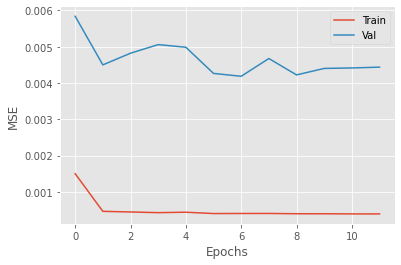

In [17]:
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

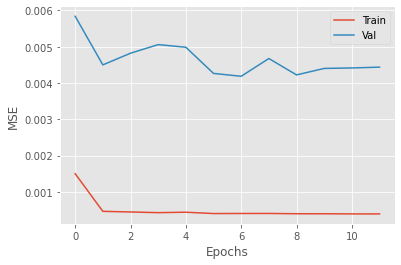

In [18]:
plt.plot(hist_1.history['mean_squared_error'])
plt.plot(hist_1.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

### 2nd LSTM Model

In [19]:
mod_2 = cmod_2(n_steps_in, n_steps_out, feature)

In [20]:
hist_2 = mod_2.fit(x_train, y_train, epochs=100 , steps_per_epoch=25, verbose=1,
         validation_data=(x_val, y_val))

Epoch 1/100
25/25 [==============================] - 2s 82ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 2/100
25/25 [==============================] - 2s 71ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 3/100
25/25 [==============================] - 2s 71ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 4/100
25/25 [==============================] - 2s 73ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0264 - val_mean_squared_error: 0.0264
Epoch 5/100
25/25 [==============================] - 2s 73ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0237 - val_mean_squared_error: 0.0237
Epoch 6/100
25/25 [==============================] - 2s 73ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 7/100
25/25 [=========

In [21]:
mod_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 90, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
activation (Activation)      (None, 30)                0         
Total params: 32,130
Trainable params: 32,130
Non-trainable params: 0
_________________________________________________________________


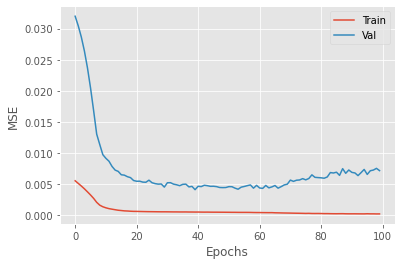

In [22]:
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

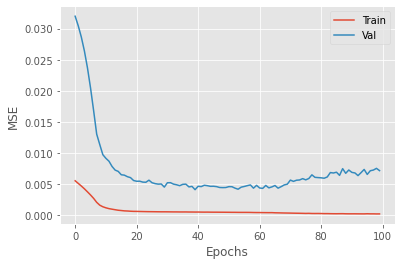

In [23]:
plt.plot(hist_2.history['mean_squared_error'])
plt.plot(hist_2.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

In [24]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))

    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [25]:
n_input = 90

# history is a list of weekly data
history = [x for x in train_set]
# walk-forward validation over each week
pred_1 = list()
for i in range(len(test_set)):
    # predict the week
    yhat_sequence = forecast(mod_1, history, n_input)
    # store the predictions
    pred_1.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test_set[i, :])
    
# evaluate predictions days for each week
pred_1 = np.array(pred_1)

In [26]:
rmse_1 = np.sqrt(np.mean(((pred_1 -test_set) ** 2)))
print(f'RMSE：{np.round(rmse_1, 4)}')

RMSE：0.1725


In [27]:
pred_it_1 = scaler.inverse_transform(pred_1)


In [28]:
test_inv = scaler.inverse_transform(test_set)


In [29]:
rmse_1 = np.sqrt(np.mean(((pred_it_1 -test_inv) ** 2)))
print(f'RMSE：{np.round(rmse_1, 4)}')


RMSE：719.668


### Model 1 Eval

In [30]:
n_input = 60

# history is a list of weekly data
history = [x for x in train_set]
# walk-forward validation over each week
pred_2 = list()
for i in range(len(test_set)):
    # predict the week
    yhat_sequence = forecast(mod_2, history, n_input)
    # store the predictions
    pred_2.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test_set[i, :])
    
# evaluate predictions days for each week
pred_2 = np.array(pred_2)

In [31]:
rmse_1 = np.sqrt(np.mean(((pred_2 - test_set) ** 2)))
print(f'RMSE：{np.round(rmse_1, 4)}')

RMSE：1090.2724


In [32]:
pred_it_2 = scaler.inverse_transform(pred_2)


In [33]:
rmse_1 = np.sqrt(np.mean(((pred_it_2 - test_inv) ** 2)))
print(f'RMSE：{np.round(rmse_1, 4)}')

RMSE：4548972.2825


In [34]:
train = price_data[:train_set_len]
test = price_data[train_set_len:]

In [35]:
test['Predictions'] = pred_it_1

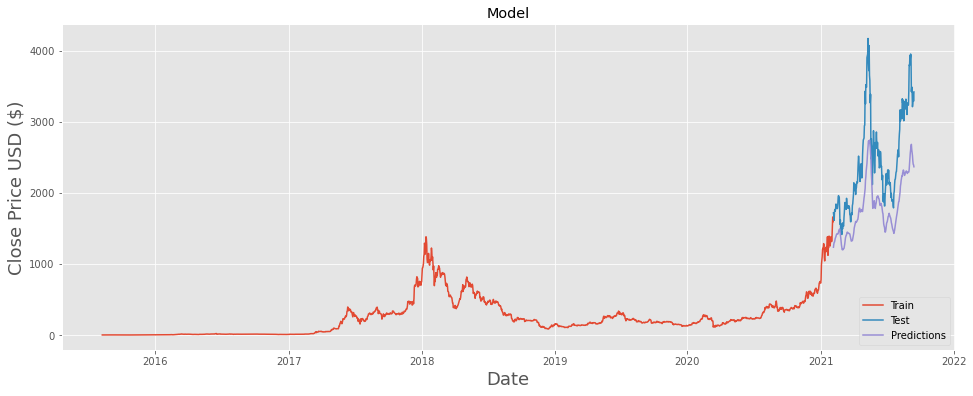

In [36]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['price_usd_close'])
plt.plot(test[['price_usd_close','Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [37]:
test

price_usd_close  Predictions
t                                       
2021-02-05      1717.685278  1235.153809
2021-02-06      1678.043157  1278.023682
2021-02-07      1614.018497  1302.717163
2021-02-08      1744.296045  1308.752686
2021-02-09      1765.741221  1336.092651
...                     ...          ...
2021-09-10      3212.099640  2524.957764
2021-09-11      3266.273666  2449.472168
2021-09-12      3410.418612  2403.614502
2021-09-13      3289.677335  2395.289307
2021-09-14      3420.800691  2367.116211

[222 rows x 2 columns]